# checking if 200 m was an appropriate delineation for the CUC

In [43]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate as interp
from scipy.stats import binned_statistic_2d
import cmocean.cm as cm
from matplotlib.patches import Rectangle
import matplotlib.colors as colors
from matplotlib.collections import PatchCollection
import datetime as dt
import math
from matplotlib.gridspec import GridSpec
import netCDF4 as nc
from pathlib import Path

## general variables:

In [17]:
mymesh = xr.open_dataset('/ocean/mdunphy/CIOPSW-BC12/grid/mesh_mask_Bathymetry_NEP36_714x1020_SRTM30v11_NOAA3sec_WCTSS_JdeFSalSea.nc')
depthf = interp.interp1d(mymesh.z, mymesh.gdept_1d)

In [3]:
Wdata17 = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_BC12/back_sahubdy_31mar18/ariane_positions_quantitative.nc')
Wdata16 = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_BC12/back_sahubdy_31mar17/ariane_positions_quantitative.nc')

In [4]:
#in the format [section, igridW, igridE, fjgrid, maxdepth] for horizontal CS
# OR for vertical [section, jgridS, jgridN, figrid, maxdepth]
Sshelf = [5, 634, 644, 200, 180] #h
Sslope = [4, 579, 633, 200, 500] #h

## lets start by simply plotting my lagrangian south boundary results but with a log plot

In [27]:
def draw_patches(fmask, lonW, lonE, t_dist, t_depths): #draw ground part of cross section
    topo = []
    for i in range(lonW,lonE):
        for j in range(len(t_depths)-1):
            if fmask[j, i] == 0:
                rect = Rectangle((t_dist[i], t_depths[j]), t_dist[i+1]-t_dist[i], t_depths[j+1]-t_depths[j])
                topo.append(rect)
    pc = PatchCollection(topo, facecolors='lightgray', zorder=3)
    return(pc)

In [38]:
def FluxEW(mydata, tracername, section, lonW, lonE, fjgrid, maxdepth, distlabel, ax, title):
    igrid = fjgrid-1
    fmask = mymesh.fmask[0, :, igrid, :]
    tmask = mymesh.tmask[0]
    nav_lon = mymesh.nav_lon[igrid]
    time = mydata.init_t[-1]
    
    t_lons = mymesh.glamt[0, igrid]
    m2lon = ((t_lons[lonE]-t_lons[lonW])/(mymesh.e1t[0, igrid, lonW:lonE].sum()))
    t_dist = t_lons/m2lon
    t_depths = mymesh.gdept_1d[0,:]
    
    bins = [np.array(t_dist[lonW-1:lonE+1]), t_depths]
    xs, ys = np.meshgrid(np.array(t_dist[lonW-1:lonE+1]), np.array(t_depths))
    
    if type(section) == list:
        lons = mydata.final_lon[np.logical_or(mydata.final_section == section[0],mydata.final_section==section[1])]
        dist = lons/m2lon
        depths = depthf(mydata.final_z[np.logical_or(mydata.final_section == section[0],mydata.final_section==section[1])]-1.)[0]
        transports = mydata.final_transp[np.logical_or(mydata.final_section == section[0],mydata.final_section==section[1])]/time
        
        H1, _, _ = np.histogram2d(dist, depths, bins=[np.array(t_dist[lonW-1:lonE+1]), t_depths],weights= transports, density= True)
        _, xedges, yedges = np.histogram2d(dist, depths, bins = bins)
    
        if tracername == 'trans':
            t_max = (0.01/np.sum(transports)).values
            tick = np.round(((t_max*sum(transports)).values),2)
            cmap = cm.speed
            units = '$m s^{-1}$'
            
            H_final = H1.T
    
        elif tracername == 'temp' or tracername == 'salt':
            if tracername == 'temp':
                tracer = mydata.init_temp[np.logical_or(mydata.final_section == section[0],mydata.final_section==section[1])]
                t_max = round(1 * 0.1,1)
                tick = t_max
                cmap = cm.rain
                units = '$C^{\circ} m s^{-1}$'
            else:
                tracer = mydata.init_salt[np.logical_or(mydata.final_section == section[0],mydata.final_section==section[1])]
                t_max = round(15 * 0.1,1)
                tick = t_max
                cmap = cm.amp
                units = '$g kg^{-1} m s^{-1}$'
        
            H = binned_statistic_2d(dist, depths, tracer, statistic=np.mean, bins=[np.array(t_dist[lonW-1:lonE+1]), t_depths])
            H_final = H1.T * H.statistic.T * float(sum(transports))
    
        else:
            print('incorrect tracer name, options are trans, salt, temp')
            
    else:
        lons = mydata.final_lon[(mydata.final_section==section)]
        dist = lons/m2lon
        depths = depthf(mydata.final_z[(mydata.final_section==section)]-1.)[0]
        transports = mydata.final_transp[(mydata.final_section==section)]/time
        
        H1, _, _ = np.histogram2d(dist, depths, bins=[np.array(t_dist[lonW-1:lonE+1]), t_depths],weights= transports, density= True)
        _, xedges, yedges = np.histogram2d(dist, depths, bins = bins)
    
        if tracername == 'trans':
            t_max = (0.01/np.sum(transports)).values
            tick = np.round(((t_max*sum(transports)).values),2)
            cmap = cm.speed
            units = '$m \, s^{-1}$'
            
            H_final = H1.T
    
        elif tracername == 'temp' or tracername == 'salt':
            if tracername == 'temp':
                tracer = mydata.init_temp[(mydata.final_section == section)]
                t_max = round(1 * 0.1,1)
                tick = t_max
                cmap = cm.rain
                units = '$C^{\circ} m s^{-1}$'
            else:
                tracer = mydata.init_salt[(mydata.final_section == section)]
                t_max = round(15 * 0.1,1)
                tick = t_max
                cmap = cm.amp
                units = '$g kg^{-1} m s^{-1}$'
        
            H = binned_statistic_2d(dist, depths, tracer, statistic=np.mean, bins=[np.array(t_dist[lonW-1:lonE+1]), t_depths])
            H_final = H1.T * H.statistic.T * float(sum(transports))
    
        else:
            print('incorrect tracer name, options are trans, salt, temp')
        

    X, Y = np.meshgrid(xedges, yedges)
    cmap.set_bad('white')
    im = ax.pcolor(X, Y, H_final, cmap=cmap, norm=colors.LogNorm(vmin=0.00000001, vmax=0.0001))
    cb1 = fig.colorbar(im, ax=ax)
#     cb1.set_ticks([0, t_max])
#     cb1.set_ticklabels([0, tick]) 
    cb1.set_label(units, labelpad=-20, fontsize=14)
    
    pc = draw_patches(fmask, lonW-2, lonE, np.array(t_dist), np.array(t_depths))
    ax.add_collection(pc)

    ax.invert_yaxis()
    ax.set_xticks([t_dist[lonW], t_dist[lonE-1]])
    ax.set_xlim((t_dist[lonW], t_dist[lonE-1]))
    ax.set_ylim((maxdepth, 0))
    ax.set_ylabel('Depth [m]', fontsize=14)
    mydata.close()
    
#     return t_dist
    return H_final

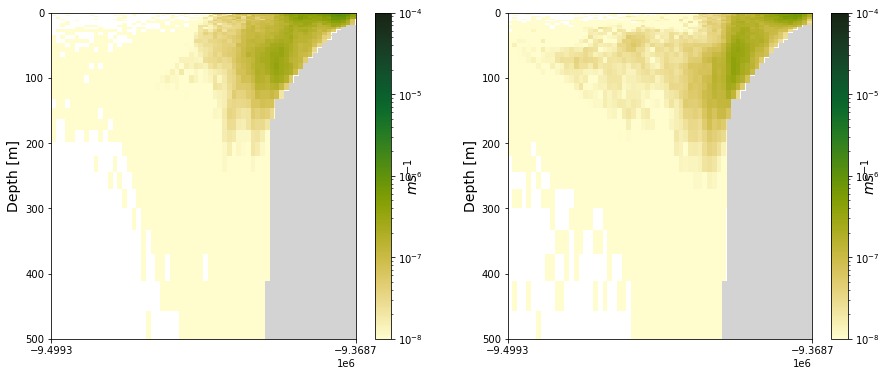

In [39]:
fig, ax = plt.subplots(1,2, figsize=[15,6])
distlabel=False
H = FluxEW(Wdata16, 'trans', [Sslope[0], Sshelf[0]], Sslope[1], Sshelf[2], Sslope[3], Sslope[4], distlabel, ax[0], 'Winter 2016/17')
H = FluxEW(Wdata17, 'trans', [Sslope[0], Sshelf[0]], Sslope[1], Sshelf[2], Sslope[3], Sslope[4], distlabel, ax[1], 'Winter 2017/18')

## Next, CS strait from the model

In [5]:
u_file = nc.Dataset("/ocean/mdunphy/CIOPSW-BC12/2017011500/BC12_1d_grid_U_20170114_20170114.nc")
v_file = nc.Dataset("/ocean/mdunphy/CIOPSW-BC12/2017011500/BC12_1d_grid_V_20170114_20170114.nc")

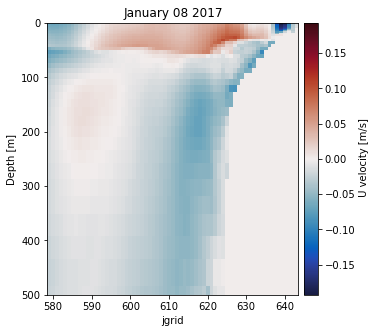

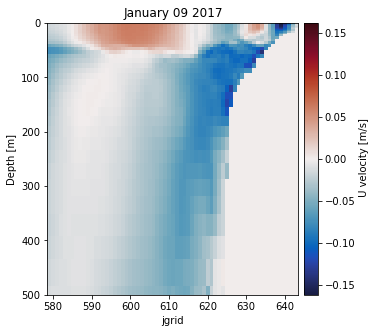

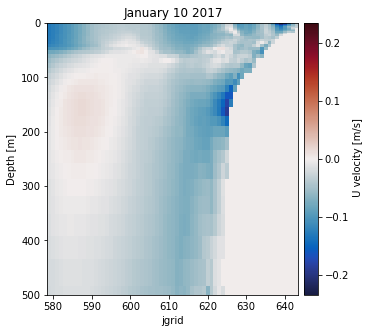

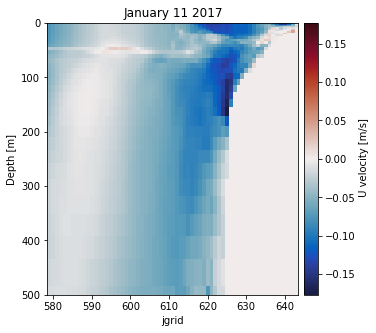

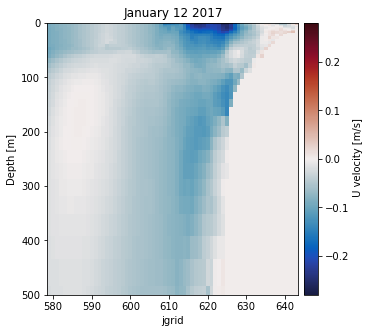

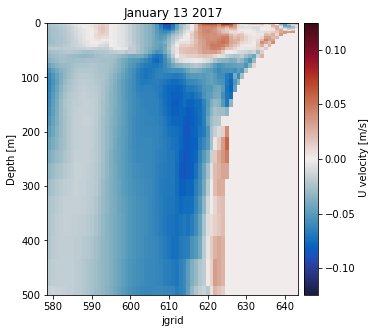

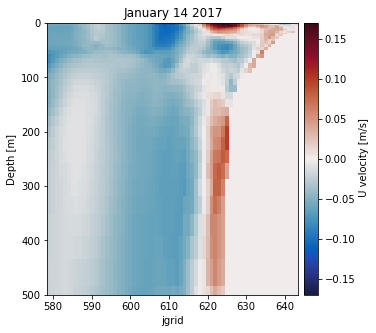

In [18]:
# nc_file = "/ocean/rbeutel/data/201701/U_new_20170101.nc"
days = ['08','09','10','11','12','13','14']

for d in days:

    u_file = nc.Dataset("/ocean/mdunphy/CIOPSW-BC12/2017011500/BC12_1d_grid_U_201701"+str(d)+"_201701"+str(d)+".nc")
    nc_to_plot = u_file
    mesh_nc = nc.Dataset('/ocean/mdunphy/CIOPSW-BC12/grid/mesh_mask_Bathymetry_NEP36_714x1020_SRTM30v11_NOAA3sec_WCTSS_JdeFSalSea.nc')

    # hours = [0, 3, 6, 12, 15, 18, 21, 24]
    # hours = [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22]

    variable = 'uo'
    fig, ax= plt.subplots(nrows=1, ncols=1, figsize =(5,5))

    # Sshelf = [5, 634, 644, 200, 180] #h
    # Sslope = [4, 579, 633, 200, 500] #h
    igrid = 200-1
    lonW = 579
    lonE = 644
    k = 0

    data = nc_to_plot[variable][0,:,igrid, lonW:lonE]
        # X, Y = np.meshgrid(nc_to_plot['nav_lat'][646,255:273], nc_to_plot['depthu'])
    section_slice = np.arange(lonW,lonE)
    zlevels = mesh_nc['gdept_1d'][:][0]
    X, Y = np.meshgrid(section_slice, zlevels)
    tmesh = ax.pcolormesh(X,Y,data, cmap = cm.balance, \
                              vmin = -1 * np.max(np.abs(data)), vmax = np.max(np.abs(data)))

    ax.set_ylim([0,500])
    ax.invert_yaxis()
    ax.set_ylabel('Depth [m]')
    ax.set_xlabel('jgrid')
    ax.set_title('January '+str(d)+' 2017')

    cbar = fig.colorbar(tmesh, ax=ax, orientation = 'vertical',fraction=0.08, pad=0.02)#, ticks = tticks)
    cbar.set_label(label=' U velocity [m/s]') 
    
# plt.tight_layout()

In [11]:
u = xr.open_dataset("/ocean/mdunphy/CIOPSW-BC12/2017011500/BC12_1d_grid_U_20170114_20170114.nc")['uo'][0,:,igrid, lonW:lonE].values
v = xr.open_dataset("/ocean/mdunphy/CIOPSW-BC12/2017011500/BC12_1d_grid_V_20170114_20170114.nc")['vo'][0,:,igrid, lonW:lonE].values
data = np.sqrt((u**2) * (v**2))

In [40]:
# waht if we averaged all the u velocities for the whole winter of 2016/17

In [60]:
startday = [dt.datetime(2016,10,2)+dt.timedelta(days=i) for i in range(int(25*7))]
folders = [dt.datetime(2016,10,2)+dt.timedelta(days=7*(i+1)) for i in range(int(25))]
folders = np.repeat(folders,7)

In [62]:
path = Path("/ocean/mdunphy/CIOPSW-BC12/")
    
    # load U
drop_vars = (
        "depthu_bounds", "nav_lat", "nav_lon", 'time_counter_bounds', 'time_instant',
        'time_instant_bounds', 
    )

files = [sorted(path.glob("{:%Y%m%d}00/BC12_1d_grid_U_{:%Y%m%d}_{:%Y%m%d}.nc".format(folders[i], startday[i], startday[i]))) for i in range(len(startday))]

In [63]:
u_mean = xr.open_mfdataset(files, drop_variables=drop_vars)['uo'].mean(dim='time_counter')

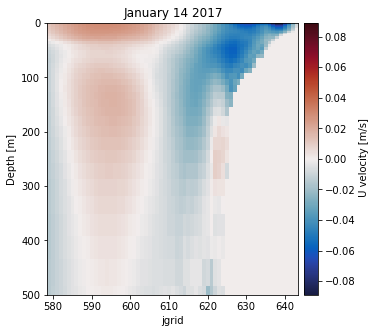

In [65]:
# nc_file = "/ocean/rbeutel/data/201701/U_new_20170101.nc"

mesh_nc = nc.Dataset('/ocean/mdunphy/CIOPSW-BC12/grid/mesh_mask_Bathymetry_NEP36_714x1020_SRTM30v11_NOAA3sec_WCTSS_JdeFSalSea.nc')
fig, ax= plt.subplots(nrows=1, ncols=1, figsize =(5,5))
igrid = 200-1
lonW = 579
lonE = 644
k = 0

data = u_mean[:,igrid, lonW:lonE].values
        # X, Y = np.meshgrid(nc_to_plot['nav_lat'][646,255:273], nc_to_plot['depthu'])
section_slice = np.arange(lonW,lonE)
zlevels = mesh_nc['gdept_1d'][:][0]
X, Y = np.meshgrid(section_slice, zlevels)
tmesh = ax.pcolormesh(X,Y,data, cmap = cm.balance, \
                              vmin = -1 * np.max(np.abs(data)), vmax = np.max(np.abs(data)))

ax.set_ylim([0,500])
ax.invert_yaxis()
ax.set_ylabel('Depth [m]')
ax.set_xlabel('jgrid')
ax.set_title('January '+str(d)+' 2017')

cbar = fig.colorbar(tmesh, ax=ax, orientation = 'vertical',fraction=0.08, pad=0.02)#, ticks = tticks)
cbar.set_label(label=' U velocity [m/s]') 
    
# plt.tight_layout()